<a href="https://colab.research.google.com/github/smallrus-web/AZSII_prz2/blob/main/%D0%90%D1%80%D1%85%D0%B8%D0%BF%D0%BE%D0%B2_%D0%94%D0%BC%D0%B8%D1%82%D1%80%D0%B8%D0%B9_%D0%90%D0%97%D0%A1%D0%98%D0%98_prz2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Практическая работа №2 Исследование атак на модели ИИ. Fast
Gradient Sign Method (FGSM)

По дисциплине: Анализ защищенности систем искусственного интеллекта

Выполнил студент группы: ББМО-01-23

Архипов Дмитрий Евгеньевич


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9735 - loss: 0.0862
Test accuracy on clean images: 0.9761999845504761


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9735 - loss: 0.0862
Точность на чистых изображениях: 0.9762


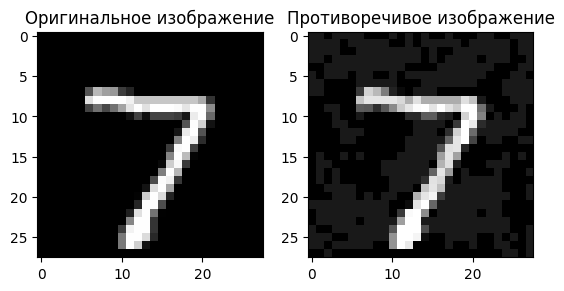

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1006 - loss: 6.6209
Точность на противоречивых примерах: 0.1332


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Скомпилируем модель, чтобы избежать предупреждения
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels)
print(f'Точность на чистых изображениях: {test_acc:.4f}')

# Функция для реализации FGSM атаки
def fgsm_attack(image, epsilon, gradient):
    # Применение знака градиента к изображению
    perturbed_image = image + epsilon * np.sign(gradient)
    # Обрезка значений, чтобы они оставались в пределах [0,1]
    perturbed_image = np.clip(perturbed_image, 0, 1)
    return perturbed_image

# Вычисление градиента
def generate_adversarial_example(model, image, label, epsilon):
    # Приведение изображения к нужному формату
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))
    label = tf.convert_to_tensor(label)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        # Применение функции потерь
        loss = tf.keras.losses.sparse_categorical_crossentropy(label[None], prediction)

    # Получение градиента по отношению к входному изображению
    gradient = tape.gradient(loss, image)
    # Применение FGSM
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
    return adversarial_image

# Пример использования
epsilon = 0.1  # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels[0], epsilon)

# Вывод результатов
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

# Генерация противоречивых примеров для всего набора данных
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        # Генерация противоречивого изображения
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image)

    return np.array(adversarial_images)

# Генерация противоречивых примеров
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images.reshape(-1, 28, 28, 1), test_labels)
print(f'Точность на противоречивых примерах: {adversarial_acc:.4f}')

In [ ]:
print(f'Test accuracy on clean images: {test_acc:.4f}')
print(f'Accuracy on adversarial examples: {adversarial_acc:.4f}')

Test accuracy on clean images: 0.9762
Accuracy on adversarial examples: 0.1332
